In [29]:
import os,sys,netCDF4

# Get dir name of parent directory
modfol=os.path.dirname(os.getcwd())
sys.path.insert(0, modfol)

# Complete import statements 
import GeneralFunctions as GF, numpy as np, matplotlib.pyplot as plt, pandas as pd, TC_Utils as tc

# Set Data directory
datadir=modfol+"/Data/"

# Setname of observations file
obsfile=datadir+"Pyramid_SCol.xlsx" # Sheetnames = "Pyramid_hour"; "SCol"


# Comparison of Daily Observations and Reanalysis Data

### Station Observations
First we import the weather station data. These data have a temporal frequency of 10 minutes, and are in Nepali time (GMT+5:45). We import into a pandas DataFrame and set the Date (first column) as the time index. We also convert to daily and drop the first obs (incomplete day)

In [2]:
obs=pd.read_excel(obsfile,sheet_name="SCol",index_col=0,parse_dates=True,names=["Temp_Obs","Press_Obs"])
obs.index =obs.index+pd.DateOffset(hours=-5.75) # note that we convert to UTC
#obs.tail(5) # <- uncomment to examine
obs_daily=(obs.resample("D").mean())[1:]
#obs_daily.head(5) # <- ditto

### Reanalysis Data
Next we iterate over all the monthly NetCDF files, (bi-linearly) interpolating to the lon (86.9250) and lat (27.9878) of Everest, and to the elevation of the South Col (7986 m). These interpolated data are inserted into a time-aware Pandas DataFrame. 

In [3]:
# To facilitate the interpolation, we write a convenience function that interpolates horizontally using the system
# install of CDO. We then interpolate vertically using Python

def interpNC(fin,zname,pname,tname,low_p,high_p,z_c):

    """
    Take variables in fin -- which is time/plevel netCDF4 Dataset and 
    interpolate to the z of interest
    
    fin   :-> netCDF4 input file
    zname :-> name of geopotential height variable
    pname :-> name of pressure level variable
    tname :-> name of temperature variable
    low_p :-> Pressure (in Pa) of surface above Everest
    high_p:-> Pressue (in Pa) of surface below South Col
    z_c   :-> height to interpolate to
    
    """
    
    # Interpolate entire file (i.e. all vars/times) horizontally with CDO 
    cmd="cdo remapbil,lon=86.93333_lat=27.96667 %s%s /tmp/scratch.nc" % (datadir,fin)
    fail=os.system(cmd); assert fail==0,"This call failed:\n%s"%cmd # system call
    
    # recycle fin to be the netCDF file
    fin=netCDF4.Dataset("/tmp/scratch.nc")
    
    # Variables for interpolation
    vs=[ii for ii in fin.variables if "lon" not in ii and "lat" not in ii and\
        "time" not in ii and zname not in ii and "z" not in ii]
    
    #Assignments and preallocation
    z=np.squeeze(fin.variables[zname][:,:]) # Height - m
    temp=np.squeeze(fin.variables[tname][:,:]) # Temp - K
    p=np.squeeze(fin.variables[pname][:]) # Pressure level 
    time=fin.variables["time"] # Time
    nt=len(time)
    nv=len(vs)
    tcount=range(nt)
    vcount=range(nv)
    out=np.zeros((len(time),len(vs)+1))*np.nan # 
    ptime=netCDF4.num2date(time[:],units=time.units,calendar=time.calendar)  

    
    # Main loop 
    for v in vcount: # Over variables
        y=np.squeeze(fin.variables[vs[v]][:])
        for t in tcount: # Over time
            if vs[v]=="level":
               out[t,v]= np.interp(z_c,z[t,::-1],p[::-1])
            else:
                out[t,v]=np.interp(z_c,z[t,::-1],y[t,::-1])    
                           
        if vs[v]=="t": # convert to deg C
            out[:,v]-=273.15
      
    # Add lapse rate (degC/km)        
    out[:,-1]=np.squeeze((temp[:,p==low_p]-temp[:,p==high_p])/\
    (z[:,p==low_p]-z[:,p==high_p]))*1e3
    
    return pd.DataFrame(data=out,columns=vs+["lapse"],index=ptime)

# Here, we list all the netCDF4 files to interpolate...
files=[ii for ii in os.listdir(datadir) if ".nc" in ii]

# And now we apply the interpolation routine (function) to all monthly files -- merging the output into a Pandas DF...
# [Note: this code is quite slow at the moment!]
mod=pd.concat([interpNC(files[ii],"z_2","level","t",300,400,7986) for ii in range(len(files))])

In [4]:
# Now we compute the daily mean for the reanalysis data (new cell is because the previous one is slow to run!)
mod_daily=mod.resample("D").mean()

### Comparing Observations and Reanalysis Data
Here we combine the two dataframes and examine the agreement between series

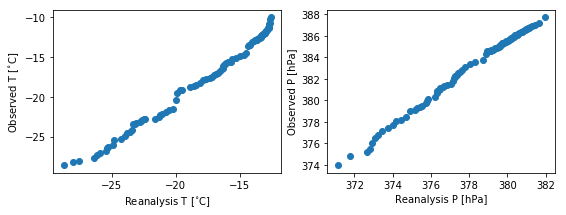

In [5]:
comb=(pd.concat([obs_daily,mod_daily],axis=1)).dropna()
# Temporal agreement between Temp and Pressure?
r_t=np.corrcoef(comb["Temp_Obs"],comb["t"])[0,1]
r_p=np.corrcoef(comb["Press_Obs"],comb["level"])[0,1]
# Quantile agreement?
pcs=np.arange(1,100,1)
qs=pd.DataFrame(data=np.percentile(comb,pcs,axis=0),columns=comb.columns,index=pcs)
# Plot the quantile agreement 
fig,ax=plt.subplots(1,2)
# Temp
ax.flat[0].scatter(qs["t"],qs["Temp_Obs"]); ax.flat[0].set_xlabel(r"Reanalysis T [$^{\circ}$C]")
ax.flat[0].set_ylabel(r"Observed T [$^{\circ}$C]")
# Pressure 
ax.flat[1].scatter(qs["level"],qs["Press_Obs"]); ax.flat[1].set_xlabel(r"Reanalysis P [hPa]")
ax.flat[1].set_ylabel(r"Observed P [hPa]")
fig.set_size_inches(9,3)


### Bias correcting the reanalysis data
The bias seems to be approximately linear for both air temperature and pressure, hence a simple scale and shift could be appropriate. However, we favour the more complete QQ mapping here as it deals with the apparent departures from linearity near the tails (particulalry evident in T) 

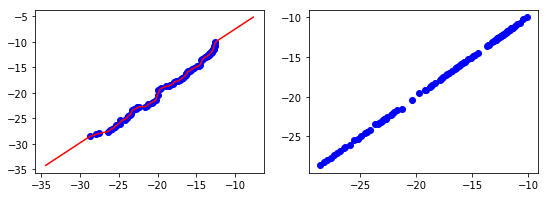

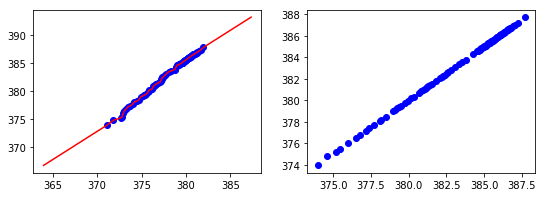

In [6]:
# Here we call the QQ mapping routine. [Note that this comes from GeneralFunctions]

# First we test the correction to illustrate the treatment
## Temp 
fig,ax=plt.subplots(1,2); fig.set_size_inches(9,3)
### Demo
test=np.linspace(np.min(comb["t"])-5,np.max(comb["t"])+5,500)
demoCorr=GF.QQmatch3(comb["Temp_Obs"],comb["t"],pcs,test,extrap=False)
ax.flat[0].plot(np.percentile(test,pcs),np.percentile(demoCorr,pcs),color="r")
ax.flat[0].scatter(qs["t"],qs["Temp_Obs"],color="b")
### Correct overlapping period
testCorr=GF.QQmatch3(comb["Temp_Obs"],comb["t"],pcs,comb["t"],extrap=False)
ax.flat[1].scatter(np.percentile(testCorr,pcs),qs["Temp_Obs"],color="b")


## Press
fig,ax=plt.subplots(1,2);fig.set_size_inches(9,3)
### Demo
test=np.linspace(np.min(comb["level"])-5,np.max(comb["level"])+5,500)
testCorr=GF.QQmatch3(comb["Press_Obs"],comb["level"],pcs,test,extrap=False)
ax.flat[0].plot(np.percentile(test,pcs),np.percentile(testCorr,pcs),color="r")
ax.flat[0].scatter(qs["level"],qs["Press_Obs"],color="b")
### Correct overlapping period
testCorr=GF.QQmatch3(comb["Press_Obs"],comb["level"],pcs,comb["level"],extrap=False)
ax.flat[1].scatter(np.percentile(testCorr,pcs),qs["Press_Obs"],color="b")

#########################################################
# Actually correct the entire period and add to mod_daily
## Temp
mod_daily["t_corr"]=GF.QQmatch3(comb["Temp_Obs"],comb["t"],pcs,mod_daily["t"],extrap=False)
## Press
mod_daily["p_corr"]=GF.QQmatch3(comb["Press_Obs"],comb["level"],pcs,mod_daily["level"],extrap=False)
#########################################################


# Adjusting bias corrected data to the summit
Here we use the bias-corrected data, along with the lapse rate and hypsometric equation, to compute the summit temperature and pressure:

\begin{eqnarray}
T_s=T_c+{\Gamma}dz\\
P_s=P_ce^{-dz g/R_d\bar{T}}
\end{eqnarray}

Where $_s$ and $_c$ denote the South Col and summit, respectively. Note that $\bar{T}$ is mean virtual temperature in the layer between the South Col and the summit. Here we make the approximation that the virtual air temperature is equal to the air temperature. This simplification is reasonable because the Tv is, on average << .1% greater than T (using raw Reanalysis specific humidity at the South Col)

In [7]:


def adjustT(temp,lapse,dz):
    """
    Simple function to take an observed temperature (temp) and adjust for a change in elevation (dz) 
    using the lapse rate (lapse)
    NB: Lapse in degC or K km^-1
    """
    temp_adj=temp+lapse/1000.*dz
    
    return temp_adj

def adjustP(press,temp,lapse,dz):
    """
    Simple function using the hypsometric equation to estimate the pressure after a change in altitude of 
    dz, given starting pressure (press) and starting temp (temp)
    """
    tav=1/2.*(temp+adjustT(temp,lapse,dz))+273.15 # NB: C-->K
    g=8.80655 # gravitational acceleration
    Rd=287 # gas constant for dry air
    press_adj=press*np.exp(-dz*g/(Rd*tav))
    
    return press_adj

mod_daily["summit_temp"]=adjustT(mod_daily["t_corr"],mod_daily["lapse"],8848-7986)
mod_daily["summit_press"]=adjustP(mod_daily["p_corr"],mod_daily["t_corr"],mod_daily["lapse"],8848-7986)
# Test the factor that Tv is larger than T by...
#vp=GF.Q2vp(mod_daily["q"],mod_daily["level"])
#mod_daily["raw_mix_rat"]=0.622*vp/(mod_daily["level"]*100-vp)
#mu_mult=np.mean(1+0.61*mod_daily["raw_mix_rat"]); print mu_mult

# Computing Summit VO$_2$ Max
Now we convert summit pressure to the inspired oxygen, pI. This differs from the available oxygen (which is 20.95% of the total pressure) due to the moistening of the air when inhaled.

The conversion to VO$_2$ max is then achived by inverting the (log-linear) regression of Bailey (2001) who performed a meta-analysis of the relationship between inspired O$_2$ and VO$_2$ Max. Note that $c$ is the conversion multiplier (1.3332239) to transform mmHg to hPa

\begin{eqnarray}
pI = c \times e^{(0.0308 \times VO_2 Max + 3.2500)}\\
pI/c = e^{(0.0308 \times VO_2 Max + 3.2500)}\\
ln(pI/c)=0.0308 \times VO_2 Max + 3.2500 \\
VO_2 Max = (ln(pI/c)-3.2500)/0.0308
\end{eqnarray}

In [8]:
mod_daily["summit_pI"]=0.2095*(mod_daily["summit_press"]-GF.satVp(36.8+273.15)/100.)
mod_daily["VO2_max"]=(np.log(mod_daily["summit_pI"]/1.3332239)-3.25)/0.0308

# Stratifying the dataset by successful summits
Here we import an excel spreadsheet with data from the Himalayan Database recording the details of all summits. These data will be used to stratify the inferred summit climate, so that we may assess the conditions experienced by humans (with and without) oxygen

In [9]:
# Load the data (and preview)
summits=pd.read_excel(datadir+"summits.xlsx",sheetname="Sheet1",index_col=9,parse_dates=True); summits.head(5)

/home/lunet/gytm3/anaconda2/lib/python2.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


name      citizen sex  age        smtmdy  \
msmtdate                                                                  
1953-05-29  Edmund Percival Hillary  New Zealand   M   33  May 29, 1953   
1953-05-29           Tenzing Norgay        India   M   39  May 29, 1953   
1956-05-23          Juerg P. Marmet  Switzerland   M   28  May 23, 1956   
1956-05-23            Ernst Schmied  Switzerland   M   31  May 23, 1956   
1956-05-24       Adolf (Dolf) Reist  Switzerland   M   35  May 24, 1956   

           mo2used mo2none  deathtype deathnote msmttime  
msmtdate                                                  
1953-05-29       Y       .          0       NaN    11:30  
1953-05-29       Y       .          0       NaN    11:30  
1956-05-23       Y       .          0       NaN    14:00  
1956-05-23       Y       .          0       NaN    14:00  
1956-05-24       Y       .          0       NaN    11:00

In [10]:
# Stratify into those who did NOT use O2
summits_no=summits[summits["mo2none"]=="Y"]; summits_no.head(5)

name    citizen sex  age        smtmdy  \
msmtdate                                                                       
1978-05-08                   Peter Habeler    Austria   M   35   May 8, 1978   
1978-05-08          Reinhold Messner (1/2)      Italy   M   33   May 8, 1978   
1978-10-14                       Hans Engl  W Germany   M   34  Oct 14, 1978   
1978-10-16  Ang Dorje Sherpa (Thamo) (1/2)      Nepal   M   29  Oct 16, 1978   
1978-10-16   Mingma Nuru Sherpa (Khumjung)      Nepal   M    0  Oct 16, 1978   

           mo2used mo2none  deathtype deathnote msmttime  
msmtdate                                                  
1978-05-08       .       Y          0       NaN    13:15  
1978-05-08       .       Y          0       NaN    13:15  
1978-10-14       .       Y          0       NaN    17:15  
1978-10-16       .       Y          0       NaN    13:45  
1978-10-16       .       Y          0       NaN    13:45

In [11]:
# And those did use O2
summits_yes=summits[summits["mo2used"]=="Y"]; summits_yes.head(5)

name      citizen sex  age        smtmdy  \
msmtdate                                                                  
1953-05-29  Edmund Percival Hillary  New Zealand   M   33  May 29, 1953   
1953-05-29           Tenzing Norgay        India   M   39  May 29, 1953   
1956-05-23          Juerg P. Marmet  Switzerland   M   28  May 23, 1956   
1956-05-23            Ernst Schmied  Switzerland   M   31  May 23, 1956   
1956-05-24       Adolf (Dolf) Reist  Switzerland   M   35  May 24, 1956   

           mo2used mo2none  deathtype deathnote msmttime  
msmtdate                                                  
1953-05-29       Y       .          0       NaN    11:30  
1953-05-29       Y       .          0       NaN    11:30  
1956-05-23       Y       .          0       NaN    14:00  
1956-05-23       Y       .          0       NaN    14:00  
1956-05-24       Y       .          0       NaN    11:00

In [13]:
# Now get unions with reconstructed climate series (3 dataFrames -- All, without O2, with O2)
climate_all_summits=summits.merge(mod_daily,left_on=summits.index,right_on=mod_daily.index) # all 
climate_no_o2_summits=summits_no.merge(mod_daily,left_on=summits_no.index,right_on=mod_daily.index) # without o2
climate_o2_summits=summits_yes.merge(mod_daily,left_on=summits_yes.index,right_on=mod_daily.index) # with o2
# print climate_o2_summits["VO2_max"].mean(), climate_no_o2_summits["VO2_max"].mean(), mod_daily["VO2_max"].mean()

# Plotting the Summit Climate
Here we generate publication-quality plots to summarise the analysis above. The following plots are generated: 
1: Mean air temperature/pressure as f(doY) (+/-stdv)
2: 


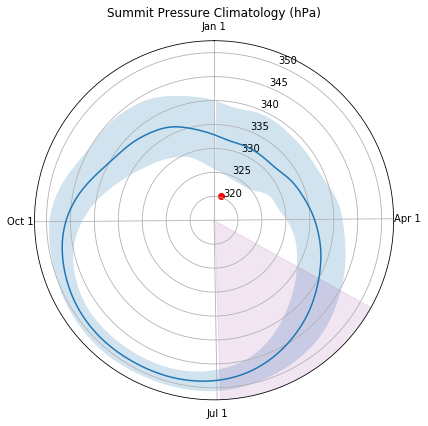

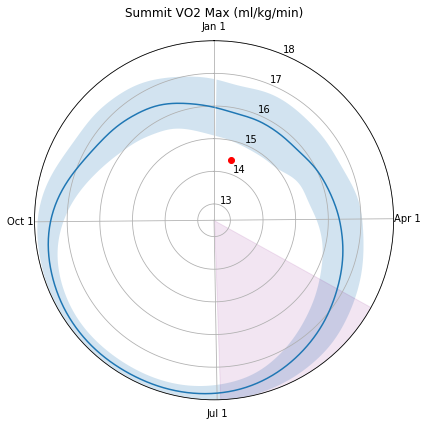

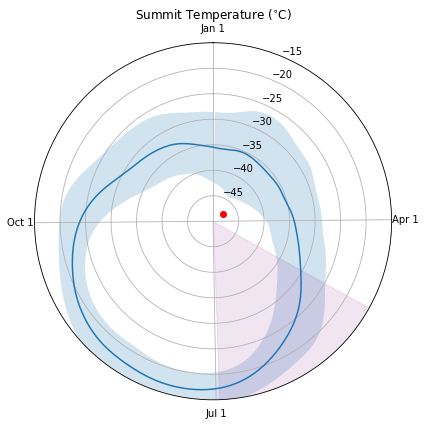

In [89]:
# Compute julian day
jd=mod_daily.index.dayofyear
theta=2*np.pi/366.*np.arange(1,367)

### Pressure
# Compute kernels
stdv=15/1.96
mu,fn_mu,all_mean=tc.kernel_smooth_doy(mod_daily["summit_press"],jd,jd,stdv) # Mean
st,fn_stdv,all_stdv=tc.kernel_smooth_stat_doy(mod_daily["summit_press"],"std",jd,jd,stdv)


# Create polar axis to draw the climatology on
fig1,ax = plt.subplots(1,1,subplot_kw={"projection":"polar"})
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.fill_between(theta,fn_mu-1.96*fn_stdv,fn_mu+1.96*fn_stdv,alpha=0.2)
ax.plot(theta,fn_mu)
ax.scatter(min_doy,minv,color="red")
# Shade may/June
ax.set_ylim(315,352.5)
ax.fill_between(np.arange(121,182)/366.*np.pi*2,315,352.5,color="purple",alpha=0.1)
# Find min and its DoY - then plot
minv=mod_daily["summit_press"].min()
min_idx=mod_daily["summit_press"]==minv
min_doy=jd[min_idx]/366.*np.pi*2
ax.scatter(min_doy,minv,color="red")


# Labels
locs=2*np.pi/366.*np.array([0,91,182,274])
labs=["Jan 1","Apr 1","Jul 1","Oct 1"]
ax.set_xticks(locs)
ax.set_xticklabels(labs)
ax.set_title("Summit Pressure Climatology (hPa)")
fig1.set_size_inches(6,6)
plt.tight_layout()

### Repeat VO2 max
# Compute kernels
stdv=15/1.96
mu,fn_mu,all_mean=tc.kernel_smooth_doy(mod_daily["VO2_max"],jd,jd,stdv) # Mean
st,fn_stdv,all_stdv=tc.kernel_smooth_stat_doy(mod_daily["VO2_max"],"std",jd,jd,stdv)
# Adjust to % of max month
#fn_mu=fn_mu/np.max(fn_mu)*100
#fn_stdv=fn_stdv/np.max(fn_mu)*100

# Create polar axis to draw the climatology on
fig2,ax = plt.subplots(1,1,subplot_kw={"projection":"polar"})
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.fill_between(theta,fn_mu-1.96*fn_stdv,fn_mu+1.96*fn_stdv,alpha=0.2)
# Find min and its DoY - then plot
minv=mod_daily["VO2_max"].min()
min_idx=mod_daily["VO2_max"]==minv
min_doy=jd[min_idx]/366.*np.pi*2
ax.scatter(min_doy,minv,color="red")
ax.plot(theta,fn_mu)
ax.set_ylim(12.5,18)
ax.fill_between(np.arange(121,182)/366.*np.pi*2,12.5,18,color="purple",alpha=0.1)



# Labels
locs=2*np.pi/366.*np.array([0,91,182,274])
labs=["Jan 1","Apr 1","Jul 1","Oct 1"]
ax.set_xticks(locs)
ax.set_xticklabels(labs)
ax.set_title("Summit VO2 Max (ml/kg/min)")
fig2.set_size_inches(6,6)
plt.tight_layout()


### Repeat Air Temperature
# Compute kernels
stdv=15/1.96
mu,fn_mu,all_mean=tc.kernel_smooth_doy(mod_daily["summit_temp"],jd,jd,stdv) # Mean
st,fn_stdv,all_stdv=tc.kernel_smooth_stat_doy(mod_daily["summit_temp"],"std",jd,jd,stdv)
# Adjust to % of max month
#fn_mu=fn_mu/np.max(fn_mu)*100
#fn_stdv=fn_stdv/np.max(fn_mu)*100

# Create polar axis to draw the climatology on
fig3,ax = plt.subplots(1,1,subplot_kw={"projection":"polar"})
ax.set_theta_offset(np.pi/2.)
ax.set_theta_direction(-1)
ax.fill_between(theta,fn_mu-1.96*fn_stdv,fn_mu+1.96*fn_stdv,alpha=0.2)
ax.plot(theta,fn_mu)
# Find min and its DoY - then plot
minv=mod_daily["summit_temp"].min()
min_idx=mod_daily["summit_temp"]==minv
min_doy=jd[min_idx]/366.*np.pi*2
ax.scatter(min_doy,minv,color="red")
ax.set_ylim(-50,-15)
# Shade may/June
ax.fill_between(np.arange(121,182)/366.*np.pi*2,-50,-15,color="purple",alpha=0.1)

# Labels
locs=2*np.pi/366.*np.array([0,91,182,274])
labs=["Jan 1","Apr 1","Jul 1","Oct 1"]
ax.set_xticks(locs)
ax.set_xticklabels(labs)
ax.set_title("Summit Temperature ($^{\circ}$C)")
fig3.set_size_inches(6,6)
plt.tight_layout()

# Export 
fig1.savefig("Pressure.png",dpi=300)
fig2.savefig("VO2.png",dpi=300)
fig3.savefig("Temp.png",dpi=300)




In [90]:
mod_daily

level          t         q         w          u          v  \
1979-01-01  368.586066 -28.238696  0.000054  0.068566  31.082371  -4.734201   
1979-01-02  370.233818 -27.134547  0.000071  0.133904  38.068018  -2.631258   
1979-01-03  371.216307 -25.853457  0.000302  0.139179  42.263404   2.746930   
1979-01-04  366.804835 -29.380281  0.000066 -0.001670  37.759397   6.474809   
1979-01-05  366.682336 -32.000121  0.000041  0.084724  28.071242  -5.705674   
1979-01-06  371.022050 -29.441016  0.000030  0.112679  14.808412 -10.710783   
1979-01-07  372.325308 -28.857400  0.000328  0.126103  26.598843  -6.780424   
1979-01-08  371.387123 -28.433392  0.000125  0.140686  18.990191  -6.412840   
1979-01-09  371.510843 -26.745596  0.000124  0.103254  21.075810  -0.004817   
1979-01-10  368.586003 -31.438895  0.000059  0.358152  20.442905  -8.532695   
1979-01-11  371.765997 -29.666248  0.000121  0.145715  17.154970  -6.711960   
1979-01-12  371.712969 -29.348166  0.000115  0.225580  20.879120  -3.731389   
1979-01-13  370.966346 -29.172461  0.000250  0.156842  22.804956  -0.154552   
1979-01-14  370.030202 -29.833113  0.000322  0.229115  28.523582   2.618300   
1979-01-15  369.041851 -31.652617  0.000279  0.128385  26.746601   7.324095   
1979-01-16  368.686582 -31.860651  0.000359  0.236735  30.927377   8.382093   
1979-01-17  367.497595 -32.481901  0.000105  0.250754  33.868429   5.995763   
1979-01-18  368.106092 -33.171511  0.000073  0.188090  26.725281   0.266510   
1979-01-19  367.656597 -32.853426  0.000346 -0.099551  24.227360   8.925484   
1979-01-20  365.406618 -34.547842  0.000201  0.122092  33.310062   6.074737   
1979-01-21  368.039404 -30.812980  0.000250  0.255540  39.373692  -3.723801   
1979-01-22  368.295453 -32.057302  0.000418  0.111567  34.733924   4.739909   
1979-01-23  367.131758 -34.506838  0.000052  0.029772  22.822145  -1.622504   
1979-01-24  368.518598 -35.689648  0.000042  0.182372   8.441867  -8.691204   
1979-01-25  371.277238 -32.210884  0.000129  0.123483  11.353280  -7.783148   
1979-01-26  367.219705 -33.466967  0.000220  0.085413  24.658668  -1.305994   
1979-01-27  363.714968 -34.718221  0.000195  0.127194  35.820011  -2.067104   
1979-01-28  364.650761 -32.678268  0.000254  0.242154  39.272270   0.641320   
1979-01-29  364.166726 -32.141438  0.000260 -0.122413  43.269109   6.516945   
1979-01-30  365.779653 -27.809123  0.000313  0.316581  54.192463  -3.187680   
...                ...        ...       ...       ...        ...        ...   
2016-12-02  372.633284 -27.113779  0.000092  0.038491  30.410700  -1.292703   
2016-12-03  373.521205 -30.057948  0.000071  0.318915   9.526330 -13.178312   
2016-12-04  376.654801 -26.933815  0.000244  0.208442   6.380952 -13.545062   
2016-12-05  376.270605 -25.417491  0.000206  0.083449  14.297807  -8.423411   
2016-12-06  376.088421 -26.551485  0.000170  0.237461  10.463654 -11.207368   
2016-12-07  377.312556 -25.042278  0.000234  0.291077  10.052161 -13.466613   
2016-12-08  377.422574 -22.451455  0.000102  0.079716  19.506692  -6.958637   
2016-12-09  376.777011 -21.883776  0.000118  0.078684  22.699442  -2.777607   
2016-12-10  376.968701 -20.270787  0.000147  0.260562  24.276211   0.419621   
2016-12-11  376.003698 -20.797676  0.000122  0.203800  30.734308   4.415796   
2016-12-12  376.169446 -22.006757  0.000180  0.220995  27.627725  -3.385778   
2016-12-13  376.012508 -22.637901  0.000237  0.242660  31.832431   5.465899   
2016-12-14  374.266158 -23.834820  0.000209  0.071144  33.613847   6.062363   
2016-12-15  374.584640 -25.683563  0.000189  0.186596  21.128748  -8.791693   
2016-12-16  376.558612 -24.179309  0.000367  0.340519  22.024504 -18.673618   
2016-12-17  375.820758 -24.580795  0.000355  0.238723  31.363419 -10.998083   
2016-12-18  376.023433 -22.881538  0.000303  0.347464  33.691569 -12.970236   
2016-12-19  376.751155 -21.026525  0.000274  0.508433  34.703467 -17.212307   
2016-12-20  377.778301 -20.463084  0.000109  0.300239  27.223796 -1